## Use case: Train and deploy an image classification model in Azure Machine Learning using MNIST dataset


* Download a dataset and look at the data
* Train an image classification model and log metrics using MLflow
* Check the Model performance matrix
* Deploy the model to a real time endpoint
* Test the model using a web request

## Import Data from Azure Open dataset

MNIST dataset is present in Azure OpenDataset library. We can use dataset directly in Azure ML Studio

In [1]:
import os
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), "/tmp/qs_data")
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

['/tmp/qs_data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/t10k-images-idx3-ubyte.gz',
 '/tmp/qs_data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/t10k-labels-idx1-ubyte.gz',
 '/tmp/qs_data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/train-images-idx3-ubyte.gz',
 '/tmp/qs_data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/train-labels-idx1-ubyte.gz']

### Visualize the dataset and understand the dataset specifications

Load the compressed files into `numpy` arrays. Then use `matplotlib` to plot 20 random images from the dataset with their labels above them. 

Note this step requires a `load_data` function that's included in an `utils.py` file. This file is placed in the same folder as this notebook. The `load_data` function simply parses the compressed files into numpy arrays.

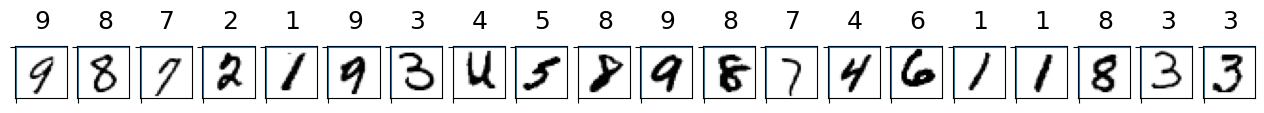

In [2]:
from utils import load_data
import matplotlib.pyplot as plt
import numpy as np
import glob


# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = (
    load_data(
        glob.glob(
            os.path.join(data_folder, "**/train-images-idx3-ubyte.gz"), recursive=True
        )[0],
        False,
    )
    / 255.0
)
X_test = (
    load_data(
        glob.glob(
            os.path.join(data_folder, "**/t10k-images-idx3-ubyte.gz"), recursive=True
        )[0],
        False,
    )
    / 255.0
)
y_train = load_data(
    glob.glob(
        os.path.join(data_folder, "**/train-labels-idx1-ubyte.gz"), recursive=True
    )[0],
    True,
).reshape(-1)
y_test = load_data(
    glob.glob(
        os.path.join(data_folder, "**/t10k-labels-idx1-ubyte.gz"), recursive=True
    )[0],
    True,
).reshape(-1)


# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 20
plt.figure(figsize=(16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline("")
    plt.axvline("")
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

In [3]:
X_train.shape

(60000, 784)

In [4]:
X_test.shape

(10000, 784)

In [5]:
y_train.shape

(60000,)

In [6]:
y_test.shape

(10000,)

## Train model and log metrics with MLflow

Train the model using the code below. I'm using MLflow autologging to track metrics and log model artifacts.
I'm using LogisticRegression to classify the data.


In [7]:
# create the model
import mlflow
import numpy as np
from sklearn.linear_model import LogisticRegression
from azureml.core import Workspace

# connect to your workspace
ws = Workspace.from_config()

# create experiment and start logging to a new run in the experiment
experiment_name = "mnist-sklearn-classification"

# set up MLflow to track the metrics
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
mlflow.set_experiment(experiment_name)
mlflow.autolog()

# set up the Logistic regression model
reg = 0.5
clf = LogisticRegression(
    C=1.0 / reg, solver="liblinear", multi_class="auto", random_state=42
)

# train the model
with mlflow.start_run() as run:
    clf.fit(X_train, y_train)

2023/02/19 07:14:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/02/19 07:14:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2023/02/19 07:14:27 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.
2023/02/19 07:14:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


In [8]:
#Classes predicted by the model
clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [9]:
clf.coef_.shape

(10, 784)

In [10]:
print(clf.predict(X_test[0:9]))
print(y_test[0:9])

[7 2 1 0 4 1 4 9 6]
[7 2 1 0 4 1 4 9 5]


In [13]:
score = clf.score(X_test, y_test)

## Check the Confusion matrix

In [14]:
from sklearn import metrics
predictions = clf.predict(X_test)

cm = metrics.confusion_matrix(y_true=y_test, 
                         y_pred = predictions, 
                        labels = clf.classes_)
cm

array([[ 960,    0,    2,    2,    1,    4,    6,    3,    1,    1],
       [   0, 1113,    3,    1,    0,    1,    5,    1,   11,    0],
       [   9,    8,  919,   20,    9,    5,   10,   12,   37,    3],
       [   4,    0,   17,  918,    2,   24,    4,   11,   21,    9],
       [   1,    3,    4,    3,  913,    0,   10,    3,    6,   39],
       [  10,    2,    0,   42,   11,  768,   17,    7,   28,    7],
       [   9,    3,    7,    2,    6,   20,  907,    1,    3,    0],
       [   2,    9,   22,    5,    8,    1,    1,  948,    5,   27],
       [  10,   15,    5,   21,   15,   26,    7,   11,  852,   12],
       [   7,    8,    2,   14,   32,   13,    0,   26,   12,  895]])

## Plot the confusion matrix

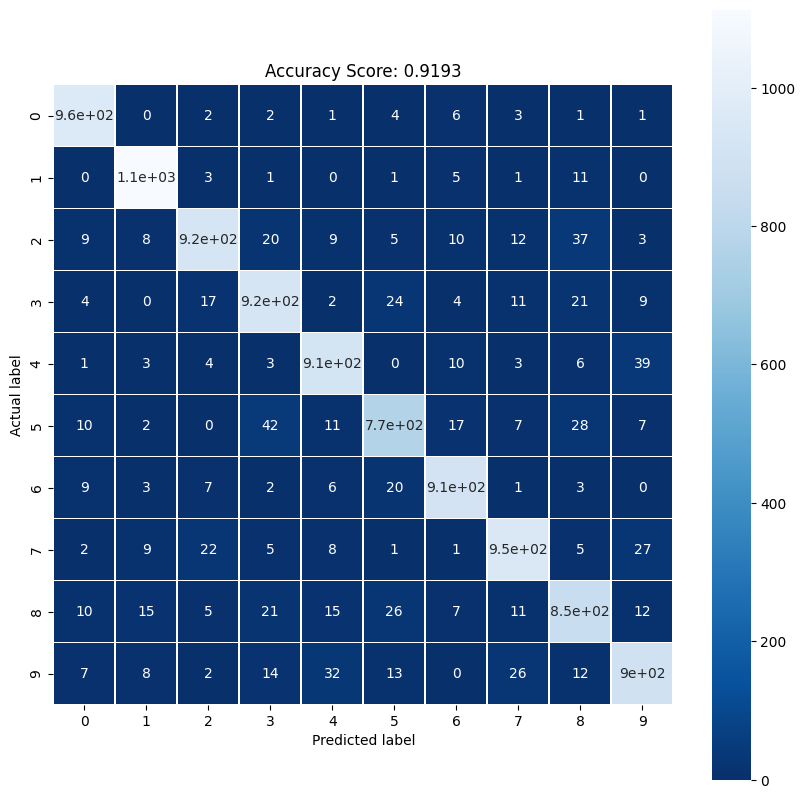

In [16]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, 
            linewidths=.5, square = True, cmap = 'Blues_r');

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title);

## Register the model to model registry

In [17]:
# register the model
model_uri = "runs:/{}/model".format(run.info.run_id)
model = mlflow.register_model(model_uri, "sklearn_mnist_model")

Registered model 'sklearn_mnist_model' already exists. Creating a new version of this model...
2023/02/19 07:19:26 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: sklearn_mnist_model, version 8
Created version '8' of model 'sklearn_mnist_model'.


## Create Deployment configuration for real time inferencing

In [18]:
# create environment for the deploy
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.webservice import AciWebservice

# get a curated environment
env = Environment.get(
    workspace=ws, 
    name="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu",
    version=1
)
env.inferencing_stack_version='latest'

# create deployment config i.e. compute resources
aciconfig = AciWebservice.deploy_configuration(
    cpu_cores=1,
    memory_gb=1,
    tags={"data": "MNIST", "method": "sklearn"},
    description="Predict MNIST with sklearn",
)

## Deploy model to an online endpoint

Below code deploys the model to Azure Container Instance (ACI). A new container instance will be created in the Resource Group and a real time endpoint will be created in Azure ML Studio. Get the REST API endpoint from the details tab of the newly created endpoint.

In [19]:
%%time
import uuid
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
from azureml.core.model import Model

# get the registered model
model = Model(ws, "sklearn_mnist_model")

# create an inference config i.e. the scoring script and environment
inference_config = InferenceConfig(entry_script="score.py", environment=env)

# deploy the service
service_name = "mnist-svc-" + str(uuid.uuid4())[:4]
service = Model.deploy(
    workspace=ws,
    name=service_name,
    models=[model],
    inference_config=inference_config,
    deployment_config=aciconfig,
)

service.wait_for_deployment(show_output=True)

<timed exec>:14: FutureWarning: azureml.core.model:
To leverage new model deployment capabilities, AzureML recommends using CLI/SDK v2 to deploy models as online endpoint, 
please refer to respective documentations 
https://docs.microsoft.com/azure/machine-learning/how-to-deploy-managed-online-endpoints /
https://docs.microsoft.com/azure/machine-learning/how-to-attach-kubernetes-anywhere 
For more information on migration, see https://aka.ms/acimoemigration. 
To disable CLI/SDK v1 deprecation warning set AZUREML_LOG_DEPRECATION_WARNING_ENABLED to 'False'


Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2023-02-19 07:19:30+00:00 Creating Container Registry if not exists.
2023-02-19 07:19:30+00:00 Registering the environment.
2023-02-19 07:19:31+00:00 Use the existing image.
2023-02-19 07:19:32+00:00 Submitting deployment to compute.
2023-02-19 07:19:35+00:00 Checking the status of deployment mnist-svc-6da9..
2023-02-19 07:21:09+00:00 Checking the status of inference endpoint mnist-svc-6da9.
Succeeded
ACI service creation operation finished, operation "Succeeded"
CPU times: user 606 ms, sys: 57.1 ms, total: 663 ms
Wall time: 1min 50s


## Test the model using the online endpoint via a web request
Test the model by sending a raw HTTP request to test the web service. 

In [22]:
# send raw HTTP request to test the web service.
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test) - 1)
input_data = '{"data": [' + str(list(X_test[random_index])) + "]}"

headers = {"Content-Type": "application/json"}

resp = requests.post(service.scoring_uri, input_data, headers=headers)
print('index: ', random_index)
print("POST to url", service.scoring_uri)
print("label:", y_test[random_index])
print("prediction:", resp.text)
print()
# print('**********')
# print()
# print(input_data)

index:  5985
POST to url http://f8771be4-4e9f-43ea-8d89-4a1aada1fd65.eastus2.azurecontainer.io/score
label: 5
prediction: [8]



### Delete the resource once testing is complete